In [1]:
# Desinstalar posibles conflictos
!pip uninstall -y tensorflow tensorflow-probability tf-agents tf-agents-nightly

# Instalar versiones compatibles
!pip install tensorflow==2.13.0
!pip install tensorflow-probability==0.21.0
!pip install tf-agents==0.17.0
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay pyglet swig
!pip install gym[atari,box2d,accept-rom-license]
!pip install gym-super-mario-bros


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successful

In [2]:
import os
import numpy as np
import tensorflow as tf
import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from IPython.display import HTML
from base64 import b64encode
import imageio
from pyvirtualdisplay import Display

from tf_agents.environments import gym_wrapper, tf_py_environment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# Pantalla virtual para renderizado en Colab
display = Display(visible=0, size=(1400, 900))
display.start()


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 244, in _register_atari_envs
    _register_atari_configs(
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 168, in _register_atari_configs
    from ale_py.roms import utils as rom_utils
ImportError: cannot import name 'utils' from 'ale_py.roms' (/usr/local/lib/python3.11/dist-packages/ale_py/roms/__init__.py)

  logger.warn(f"plugin: {plugin.value} raised {traceback.format_exc()}")


In [3]:
def create_mario_env(version="v1"):
    env = gym_super_mario_bros.make(f"SuperMarioBros-{version}")
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = GrayScaleObservation(env, keep_dim=True)
    env = ResizeObservation(env, 84)
    env = FrameStack(env, 4)
    return gym_wrapper.GymWrapper(env)

train_py_env = create_mario_env("v1")
eval_py_env = create_mario_env("v1")
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


In [4]:
# === Mostrar especificaciones del entorno de TF-Agents ===
print("🔍 Observación (spec):", train_env.observation_spec())
print("🎮 Acción (spec):", train_env.action_spec())

# También puedes imprimir las posibles acciones en texto
print("🕹️ Acciones disponibles:", SIMPLE_MOVEMENT)
print("Número total de acciones:", len(SIMPLE_MOVEMENT))

🔍 Observación (spec): BoundedTensorSpec(shape=(4, 84, 84, 1), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))
🎮 Acción (spec): BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(6))
🕹️ Acciones disponibles: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
Número total de acciones: 7


🎯 Espacio de Observación

Forma (shape): (4, 84, 84, 1)
→ Son 4 frames consecutivos (por el FrameStack)
→ Cada frame es una imagen de 84x84 píxeles
→ Con 1 canal (escala de grises)

La observación es una secuencia de 4 imágenes 84×84 en escala de grises, que representa cómo se veía la pantalla en los últimos 4 momentos. Esto le da a la red información sobre el movimiento, no solo del estado actual.

Tipo de datos (dtype): tf.uint8
→ Son valores de píxeles de 0 a 255


🎮 Espacio de Acción

El espacio de acción es discreto, con 7 acciones posibles numeradas del 0 al 6.

| Índice | Acción                | Descripción           |
| ------ | --------------------- | --------------------- |
| 0      | `['NOOP']`            | No hace nada          |
| 1      | `['right']`           | Camina a la derecha   |
| 2      | `['right', 'A']`      | Camina y salta        |
| 3      | `['right', 'B']`      | Camina y corre        |
| 4      | `['right', 'A', 'B']` | Corre y salta         |
| 5      | `['A']`               | Solo salta            |
| 6      | `['left']`            | Camina a la izquierda |


In [5]:
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]
preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, tf.float32) / 255.0)

q_net = QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params,
)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.01)
train_step_counter = tf.Variable(0)

agent = DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    gamma=0.99,
    epsilon_greedy=0.1,
    target_update_period=10000,
)
agent.initialize()


In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000,
)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

def collect_step(env, policy, buffer):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# Inicializar buffer con política aleatoria
for _ in range(2000):
    collect_step(train_env, random_policy, replay_buffer)

# Dataset
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=32, num_steps=2).prefetch(3)
iterator = iter(dataset)

# Entrenamiento
# Entrenamiento optimizado con penalización por estancamiento
@tf.function
def train_one_step(experience):
    return agent.train(experience).loss

max_iterations = 100000
steps_per_iteration = 1
stuck_counter = 0
reward_window = []
losses = []
rewards = []

for iteration in range(max_iterations):
    for _ in range(steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    experience, _ = next(iterator)
    train_loss = train_one_step(experience)
    
    # Obtener recompensa del batch
    reward_sum = tf.reduce_sum(experience.reward).numpy()
    reward_window.append(reward_sum)
    losses.append(train_loss.numpy())
    rewards.append(reward_sum)
    # Ventana deslizante de tamaño 10
    if len(reward_window) > 10:
        reward_window.pop(0)

    # Detectar estancamiento: si las recompensas no mejoran en 300 pasos (~10 iteraciones)
    if len(reward_window) == 10 and np.std(reward_window) < 1e-3:
        stuck_counter += 1
    else:
        stuck_counter = 0

    if stuck_counter >= 30:  # 30 x 10 = ~300 pasos
        print("⚠️ Estancamiento detectado. Reiniciando replay buffer...")
        replay_buffer.clear()
        stuck_counter = 0

    if iteration % 500 == 0:
        print(f"🔁 Iteración {iteration}: pérdida = {train_loss:.4f}")



/tmp/__autograph_generated_filedl5mpcc6.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  retval_ = ag__.and_(lambda: ag__.ld(state) is not None, lambda: ag__.and_(lambda: ag__.ld(state) is not (), lambda: ag__.ld(state) is not []))
/tmp/__autograph_generated_file1qqlzba5.py:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.not_(ag__.or_(lambda: ag__.ld(policy_state) is None, lambda: ag__.or_(lambda: ag__.ld(policy_state) is (), lambda: ag__.ld(policy_state) is []))), if_body_2, else_body_2, get_state_2, set_state_2, (), 0)
/tmp/__autograph_generated_filefk8zxucn.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(policy_state) is (), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_'), 2)


🔁 Iteración 0: pérdida = 0.9402
🔁 Iteración 500: pérdida = 0.5540
🔁 Iteración 1000: pérdida = 0.2442
🔁 Iteración 1500: pérdida = 0.4005
🔁 Iteración 2000: pérdida = 0.0593
🔁 Iteración 2500: pérdida = 0.1740
🔁 Iteración 3000: pérdida = 0.1318
🔁 Iteración 3500: pérdida = 0.2508
🔁 Iteración 4000: pérdida = 0.0642
🔁 Iteración 4500: pérdida = 0.2176
🔁 Iteración 5000: pérdida = 0.0943
🔁 Iteración 5500: pérdida = 0.0644
🔁 Iteración 6000: pérdida = 0.3963
🔁 Iteración 6500: pérdida = 0.0659
🔁 Iteración 7000: pérdida = 0.2703
🔁 Iteración 7500: pérdida = 0.0682
🔁 Iteración 8000: pérdida = 0.1502
🔁 Iteración 8500: pérdida = 0.0542
🔁 Iteración 9000: pérdida = 0.2418
🔁 Iteración 9500: pérdida = 0.1759
🔁 Iteración 10000: pérdida = 1.2013
🔁 Iteración 10500: pérdida = 0.3133
🔁 Iteración 11000: pérdida = 0.2017
🔁 Iteración 11500: pérdida = 0.1974
🔁 Iteración 12000: pérdida = 0.1692
🔁 Iteración 12500: pérdida = 0.2327
🔁 Iteración 13000: pérdida = 0.2520
🔁 Iteración 13500: pérdida = 0.1140
🔁 Iteración 1400

In [7]:
#returns = []
#for episode in range(5):
#    time_step = eval_env.reset()
#    total_reward = 0
#    while not time_step.is_last():
#        action_step = agent.policy.action(time_step)
#        time_step = eval_env.step(action_step.action)
#        total_reward += time_step.reward
#    print(f"✅ Episodio {episode + 1}: recompensa total: {total_reward.numpy()[0]:.2f}")
#    returns.append(total_reward.numpy()[0])


In [8]:
def record_mario_video(agent, max_steps=500, fps=30, filename='mario_fixed.mp4'):
    env = gym_super_mario_bros.make("SuperMarioBros-v1")  # SIN render_mode
    env = JoypadSpace(env, SIMPLE_MOVEMENT)

    obs = env.reset()
    dummy_time_step = train_env.reset()
    frames = []
    total_reward = 0

    for step in range(max_steps):
        # ⬇️ CAPTURA FUNCIONAL DE FRAME
        frames.append(env.screen.copy())

        # Preprocesamiento de observación
        obs_proc = np.expand_dims(obs, axis=0).astype(np.uint8)
        obs_proc = tf.image.rgb_to_grayscale(obs_proc)
        obs_proc = tf.image.resize(obs_proc, (84, 84))
        obs_proc = tf.cast(obs_proc, tf.uint8)
        obs_proc = tf.stack([obs_proc] * 4, axis=1)  # (1, 4, 84, 84, 1)

        time_step = dummy_time_step._replace(observation=obs_proc)
        action_step = agent.policy.action(time_step)
        action = int(action_step.action.numpy()[0])

        obs, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    env.close()

    output_path = f"/tmp/{filename}"
    imageio.mimsave(output_path, frames, fps=fps)
    print(f"🎥 Video guardado en: {output_path} | Recompensa total: {total_reward:.2f}")
    return output_path

def display_video(video_path):
    mp4 = open(video_path, 'rb').read()
    b64 = b64encode(mp4).decode()
    return HTML(f'<video width=480 controls><source src="data:video/mp4;base64,{b64}" type="video/mp4"></video>')


In [9]:
video_path = record_mario_video(agent, max_steps=4000)
display_video(video_path)


🎥 Video guardado en: /tmp/mario_fixed.mp4 | Recompensa total: -200.00


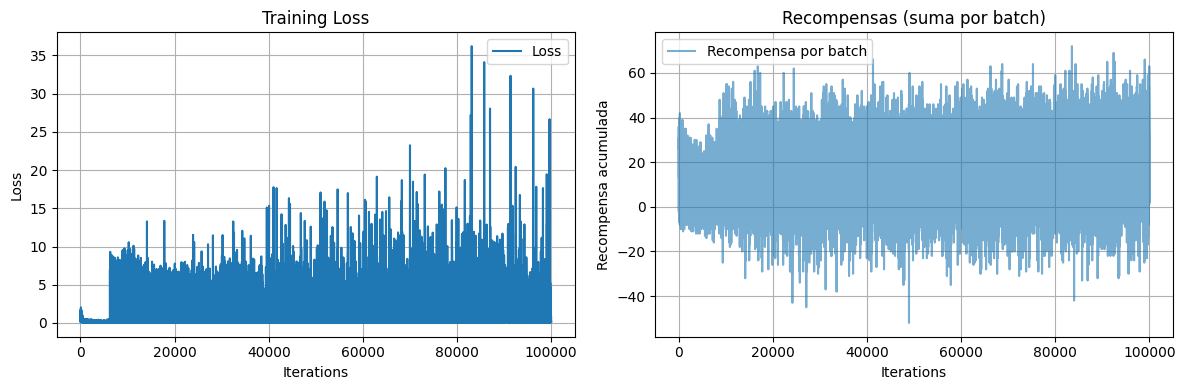

In [10]:
import matplotlib.pyplot as plt

# === Gráfica del loss ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# === Gráfica de la recompensa ===
plt.subplot(1, 2, 2)
plt.plot(rewards, label='Recompensa por batch', alpha=0.6)
plt.title("Recompensas (suma por batch)")
plt.xlabel("Iterations")
plt.ylabel("Recompensa acumulada")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from tf_agents.policies import policy_saver

# === GUARDAR CHECKPOINT ===
checkpoint_dir = "/tmp/mario_dqn_checkpoints"
policy_dir = "/tmp/mario_dqn_policy"

# Guardar checkpoint del agente (para reanudar entrenamiento)
checkpoint = tf.train.Checkpoint(agent=agent)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
manager.save()
print(f"💾 Checkpoint guardado en {checkpoint_dir}")

# === GUARDAR POLÍTICA ENTRENADA ===
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)
print(f"✅ Política guardada en {policy_dir}")



💾 Checkpoint guardado en /tmp/mario_dqn_checkpoints


/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


✅ Política guardada en /tmp/mario_dqn_policy
